# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 2.5 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, mean_absolute_error
import matplotlib.pyplot as plt
# Import models you're considering
from google.colab import drive
drive.mount('/content/drive')
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


from sklearn.model_selection import GridSearchCV


Mounted at /content/drive


/tmp/ipython-input-2017809106.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## Model Selection


We consider a neural network or an LSTM (those were used in the models in the literature review)



## Feature Engineering

Three feature engeneering steps were performed: Instead of using the max und min temperature, the span of temperature of that day was used. --> Tells if the weather was stable or fluctuating that day

The interaction between the average Temperature and the humidity is used -->There is a correlation between these two parameters


The pressure change is also interesting, a decreasing pressure indicates a low pressure area, an increasing pressure indicates a high pressure area


In [ ]:
df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Dobersdorf_all_cut_final.csv',
    nrows=5
)
print(df)

   Tag  Monat  Jahr Produktion(kWH)         Tavg  Tmin  Tmax          Hum  \
0   16      7  2023           55,79  18,22083333  15,8  22,1  74,91666667   
1   17      7  2023           54,63  16,38333333  12,4  19,4        78,75   
2   18      7  2023           65,68  16,70416667  11,8  21,6  73,54166667   
3   19      7  2023           28,26      14,7125  12,7  17,2       85,625   
4   20      7  2023           58,93  14,91666667  10,7  19,4         76,5   

           VPD Prec  Pbin         Wspd Wmax         Wdir          Cld   Sol  \
0   0,56164731  0,8     1  4,445833333    7  219,5186547        6,125  1991   
1  0,424523113    7     1  3,929166667    6  236,8576391  6,041666667  2102   
2  0,577180231    0     1  2,941666667  5,3    253,92248  5,416666667  2578   
3  0,247361166  2,9     1  1,820833333  2,9  244,7083359  7,291666667  1121   
4  0,447117605  0,3     1        3,625  6,1  268,2167486  3,708333333  2456   

    Sun         Pres          Vis  Soil  
0   7,7  1004,179167

In [3]:
# Load the dataset
# Replace 'your_dataset.csv' with the path to your actual dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dobersdorf_all_cut_final.csv', sep=",",  header=0)
print(df.columns.tolist())
print(df.dtypes)

####the floats are not recognized as floats
for col in df.columns:
    if df[col].dtype == object:
        df[col] = (
            df[col].str.replace(',', '.', regex=False).pipe(pd.to_numeric, errors='ignore')
        )
print(df.dtypes)
# Perform any feature engineering steps
# Example: df['new_feature'] = df['feature1'] + df['feature2']
df['temp_range'] = df['Tmax'] - df['Tmin']
df['temp_hum_interaction'] = df['Tavg'] * df['Hum']
##.diff() calculates the difference to the value the day before
df['pressure_change'] = df['Pres'].diff()

# Feature and target variable selection
X = df[['Tavg', 'temp_range','temp_hum_interaction','Sun','Pres','pressure_change','Vis', 'Tmin']]
y = df['Produktion(kWH)']
###values between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = np.array(y).reshape(-1, 1)
y_scaled = scaler.fit_transform(y)

print (int(len(df))*0.7)
print (int(len(df))*0.15)
print (int(len(df)))


split_index = int(len(df) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

# Split the dataset
##Splitting time series data random is problematic
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))
print(X_train)
print(y_train)

###here we had to exclude missing values
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)

print("X nan:", np.isnan(X_train).any())
print("y nan:", np.isnan(y_train).any())
print("X inf:", np.isinf(X_train).any())
print("y inf:", np.isinf(y_train).any())

###here we had to exclude missing values
X_test= np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

print("X nan:", np.isnan(X_train).any())
print("y nan:", np.isnan(y_train).any())
print("X inf:", np.isinf(X_train).any())
print("y inf:", np.isinf(y_train).any())

['Tag', 'Monat', 'Jahr', 'Produktion(kWH)', 'Tavg', 'Tmin', 'Tmax', 'Hum', 'VPD', 'Prec', 'Pbin', 'Wspd', 'Wmax', 'Wdir', 'Cld', 'Sol', 'Sun', 'Pres', 'Vis', 'Soil']
Tag                 int64
Monat               int64
Jahr                int64
Produktion(kWH)    object
Tavg               object
Tmin               object
Tmax               object
Hum                object
VPD                object
Prec               object
Pbin                int64
Wspd               object
Wmax               object
Wdir               object
Cld                object
Sol                object
Sun                object
Pres               object
Vis                object
Soil               object
dtype: object
Tag                  int64
Monat                int64
Jahr                 int64
Produktion(kWH)    float64
Tavg               float64
Tmin               float64
Tmax               float64
Hum                float64
VPD                float64
Prec               float64
Pbin                 int64
Wsp

/tmp/ipython-input-997342656.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col].str.replace(',', '.', regex=False).pipe(pd.to_numeric, errors='ignore')


## Hyperparameter Tuning

[Discuss any hyperparameter tuning methods you've applied, such as Grid Search or Random Search, and the rationale behind them.]


In [ ]:
!pip install scikeras
!pip install -U scikit-learn scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 72.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [4]:
def dimension_train(X, y, time_step=1):
      X1, y1 = [], []
      X = np.array(X)
      y = np.array(y)
      for i in range(len(X) - time_step):
        X1.append(X[i:i+time_step,:])
        y1.append(y[i+time_step])
      return np.array(X1), np.array(y1)

time_step = 10
X,y=dimension_train(X_train,y_train, time_step)

print(len(X))
print(len(y))


722
722


In [ ]:
# Implement hyperparameter tuning
# Example using GridSearchCV with a DecisionTreeClassifier
# param_grid = {'max_depth': [2, 4, 6, 8]}
# grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
# grid_search.fit(X_train, y_train)
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
time_step = 10
def model1(units=40,learning_rate=0.1):
  model1 = Sequential()
  model1.add(Input(shape=(time_step, 8)))
  model1.add(LSTM(units, return_sequences=True))
  model1.add(LSTM(units))
  model1.add(Dense(1))
  model1.compile(optimizer = keras.optimizers.Adam( learning_rate=learning_rate), loss='mean_squared_error')
  return model1

model = KerasRegressor(
    model=model1,
    verbose=0
)


###I wanted to test more parameters, but it took so long and the runtime disconnected without finishing###
param_grid = {
    "model__units": [20, 30],
    "batch_size": [8, 16],
    "epochs": [10, 20],
    "model__learning_rate": [0.00001,0.000001]

}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X, y)



,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",KerasRegresso...se epochs=1 )
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'batch_size': [8, 16], 'epochs': [10, 20], 'model__learning_rate': [1e-05, 1e-06], 'model__units': [20, 30]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is

In [ ]:
print(grid_search.best_params_)

{'batch_size': 8, 'epochs': 20, 'model__learning_rate': 1e-05, 'model__units': 30}


## Implementation

[Implement the final model(s) you've selected based on the above steps.]


In [5]:


# Build the LSTM model(with hyperparameters)
model = Sequential()
model.add(LSTM(30, return_sequences=True, input_shape=(time_step, 8)))
model.add(LSTM(30))
model.add(Dense(1))
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.00001), loss='mean_squared_error')

# Train the model
result=model.fit(X, y, epochs=20, batch_size=8,validation_split=0.15)





/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0645 - val_loss: 0.1899
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0571 - val_loss: 0.1638
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0502 - val_loss: 0.1462
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0531 - val_loss: 0.1344
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0531 - val_loss: 0.1276
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0494 - val_loss: 0.1220
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0480 - val_loss: 0.1180
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0489 - val_loss: 0.1145
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0506 - val_loss: 0.1118
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0446 - val_loss: 0.1094
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0481 - val_loss: 0.1068
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0

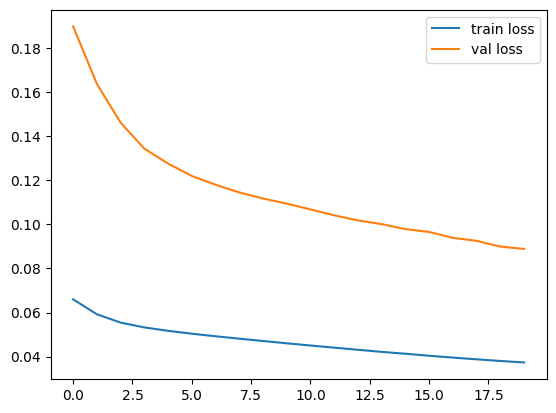

In [6]:
plt.plot(result.history["loss"], label="train loss")
plt.plot(result.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [7]:
print(len(X_test))
print(len(y_test))
###For the test sets
def dimension_test(X, y, time_step=1):
      X2, y2 = [], []
      X = np.array(X)
      y = np.array(y)
      for i in range(len(X) - time_step):
        X2.append(X[i:i+time_step,:])
        y2.append(y[i + time_step - 1])
      return np.array(X2), np.array(y2)

time_step = 10
X_test1,y_test1=dimension_test(X_test,y_test, time_step)
print(len(X_test1))
print(len(y_test1))


183
183
173
173


## Evaluation Metrics

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]


In [9]:
# Evaluate the model using your chosen metrics
# Example for classification
# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))
y_pred = model.predict(X_test1)
mse = mean_squared_error(y_test1, y_pred)
print("Mean squared error is:",mse)
mae= mean_absolute_error(y_test1, y_pred)
print("Mean absolute error is:",mae)

final=mae/np.max(y_test1)*100
print(final)



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Mean squared error is: 0.02735465774130326
Mean absolute error is: 0.14587508855723239
17.676464576058414


## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [14]:
# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model
##Comparing the Mse
##replace with new value
baseline_mse= 0.01206
print(f"Baseline Model mse: {baseline_mse}, New Model Accuracy: {mse:.4}")
print(f"The percentage error is: {final:.4} %")


Baseline Model mse: 0.01206, New Model Accuracy: 0.02735
The percentage error is: 17.68 %
